# Module 1.10: Lie Detector 6 — When Diagnostics Lie

> **Goal:** Select 6 anchor metrics, synthesize into 2 scores, and understand how they enrich S-B classification.

### From 50 Metrics to 6 That Matter

Module 1.09 computed diagnostics. Too many to act on.

| 1.09 Did | 1.10 Does |
|----------|----------|
| Compute everything | Select what matters |
| Observe distributions | Understand interactions |
| 45 metrics per series | 6 anchors → 2 scores |
| "What exists?" | "When can we trust it?" |

The **Lie Detector 6 (LD6)** is a principled reduction — 3 metrics for Structure, 3 for Chaos.

**5Q Lens:** Q4 (Data & Drivers) — Synthesize diagnostics into actionable scores

---

## 1. Setup

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import forecast_foundations as ff
from tsforge import CalculateThresholds
from tsforge.plots import plot_metric_interaction, plot_demand_classification, plot_score_distributions
from tsforge.eda.diagnostics import assign_sb_quadrant

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

env = ff.setup_notebook()
DATA_DIR = env.DATA_DIR
cache = env.cache
output = env.output

✓ Setup complete | Root: real-world-forecasting-foundations | Notebook: 1.10_lie_detector | Data: /Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data | Cache: on


---

## 2. Load Data

In [2]:
# Load diagnostics (45+ metrics per series)
diagnostics = output.load('1.09_diagnostics')

# Load weekly data for time series plots later
weekly_df = output.load('1.08_data_preparation')

✓ Loaded '1.09_diagnostics'
   Shape: 30,490 × 50
✓ Loaded '1.08_data_preparation'
   Shape: 6,848,887 × 21


In [3]:
# Quick check
print(f"Diagnostics: {diagnostics.shape[0]:,} series × {diagnostics.shape[1]} metrics")
diagnostics.head(3)

Diagnostics: 30,490 series × 50 metrics


,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,diff2_acf1,diff2_acf10,seas_acf1,cv2,adi,item_id,dept_id,cat_id,store_id,state_id
0,FOODS_1_001_CA_1,0.772978,283,-238.087160,0.464131,0.250347,0.0,0.0,0.165089,1,...,-0.685183,0.539962,-0.111695,0.505594,1.105469,FOODS_1_001,FOODS_1,FOODS,CA_1,CA
1,FOODS_1_001_CA_2,0.827633,283,-203.367626,0.796027,0.267957,0.0,0.0,0.171234,1,...,-0.667034,0.555232,0.039438,0.503956,1.105469,FOODS_1_001,FOODS_1,FOODS,CA_2,CA
2,FOODS_1_001_CA_3,0.797488,283,-253.771210,0.836479,0.151329,0.0,0.0,0.123224,1,...,-0.639856,0.514713,-0.042894,0.636649,1.118577,FOODS_1_001,FOODS_1,FOODS,CA_3,CA


---

## 3. The Lie Detector 6

<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 700px; text-align: center;">
<strong>6 metrics that separate signal from noise</strong><br>
<em>3 for Structure (learnable patterns) + 3 for Chaos (instability)</em>
</div>

### 3.1 Why These 6?

| Camp | Metric | Question | High Value Means |
|------|--------|----------|------------------|
| **Structure** | `trend` | Is there directional movement? | Strong up/down pattern |
| **Structure** | `seasonal_strength` | Is there a repeating cycle? | Reliable weekly/yearly pattern |
| **Structure** | `x_acf1` | Does last week predict this week? | High persistence (autocorrelation) |
| **Chaos** | `entropy` | How random is the sequence? | Unpredictable, coin-flip behavior |
| **Chaos** | `adi` | How sparse is demand? | Long gaps between non-zero values |
| **Chaos** | `lumpiness` | Does variance change over time? | Unstable, regime-shifting behavior |

In [4]:
# The Lie Detector 6
STRUCTURE_COLS = ['trend', 'seasonal_strength', 'x_acf1']
CHAOS_COLS = ['entropy', 'adi', 'lumpiness']
LD6_COLS = STRUCTURE_COLS + CHAOS_COLS

In [5]:
# Keep LD6 + identifiers + hierarchy + cv2 (for S-B)
id_cols = ['unique_id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
keep_cols = [c for c in id_cols if c in diagnostics.columns] + LD6_COLS

if 'cv2' in diagnostics.columns:
    keep_cols.append('cv2')

ld6_df = diagnostics[keep_cols].copy()
ld6_df.head()

,unique_id,item_id,dept_id,cat_id,store_id,state_id,trend,seasonal_strength,x_acf1,entropy,adi,lumpiness,cv2
0,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0.204450,0.376623,0.333107,0.850729,1.105469,0.360278,0.505594
1,FOODS_1_001_CA_2,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,0.223280,0.439298,0.395002,0.843529,1.105469,0.212689,0.503956
2,FOODS_1_001_CA_3,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,0.162804,0.384099,0.249157,0.895521,1.118577,0.058872,0.636649
3,FOODS_1_001_CA_4,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,0.110839,0.479389,0.274281,0.873170,1.276018,0.049412,0.690184
4,FOODS_1_001_TX_1,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,0.260977,0.376637,0.256359,0.866836,1.200855,0.105567,0.828311


In [6]:
# Quick stats on the LD6
ld6_df[LD6_COLS].describe().round(3)

,trend,seasonal_strength,x_acf1,entropy,adi,lumpiness
count,30490.000,30490.000,30490.000,30490.000,30490.000,30490.000
mean,0.394,0.582,0.381,0.802,1.454,0.217
std,0.263,0.194,0.238,0.097,0.675,0.302
min,0.000,0.167,-0.370,0.279,1.000,0.000
25%,0.187,0.436,0.190,0.750,1.085,0.049
50%,0.340,0.523,0.384,0.828,1.237,0.127
75%,0.548,0.683,0.567,0.878,1.551,0.267
max,1.000,1.000,0.944,0.997,19.636,5.768


---

## 4. When Diagnostics Lie

<div style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 700px; text-align: center;">
<strong>Metrics interact — high chaos can invalidate structure</strong><br>
<em>Trust the safest interpretation when metrics disagree</em>
</div>

The LD6 works as a **system**, not 6 isolated numbers. When chaos metrics are high, structure metrics become unreliable.

### 4.1 Trend × ADI: When Trend Lies

<Axes: title={'center': 'Trend × ADI: When Trend Lies'}, xlabel='Trend', ylabel='Adi'>

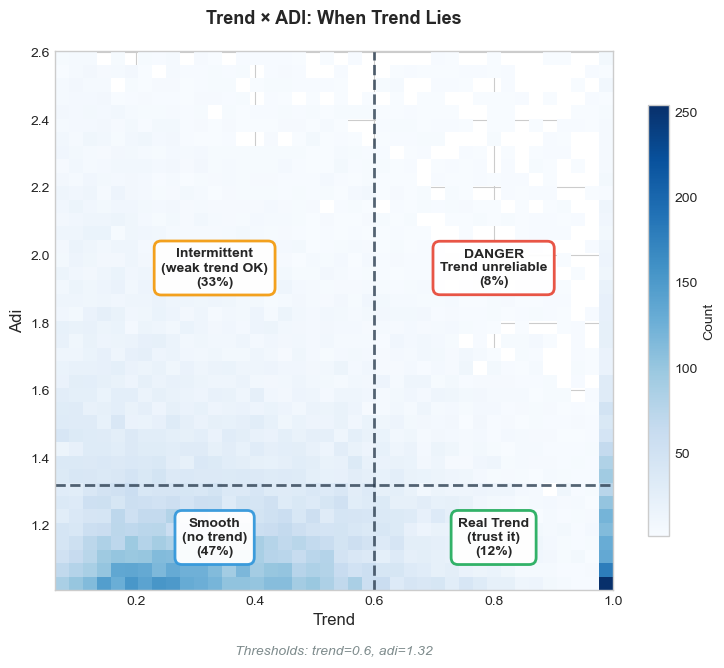

In [7]:
# When ADI is high (intermittent), trend becomes meaningless
plot_metric_interaction(ld6_df, x_col='trend', y_col='adi', title='Trend × ADI: When Trend Lies')

**Interpretation:** Series in the upper-right have "high trend" but also high ADI (intermittent). The trend is likely an artifact of sparse data — a few non-zero points happening to slope upward. Don't trust it.

### 4.2 Seasonality × ADI: When Seasonality Lies

<Axes: title={'center': 'Seasonality × ADI: When Seasonality Lies'}, xlabel='Seasonal Strength', ylabel='Adi'>

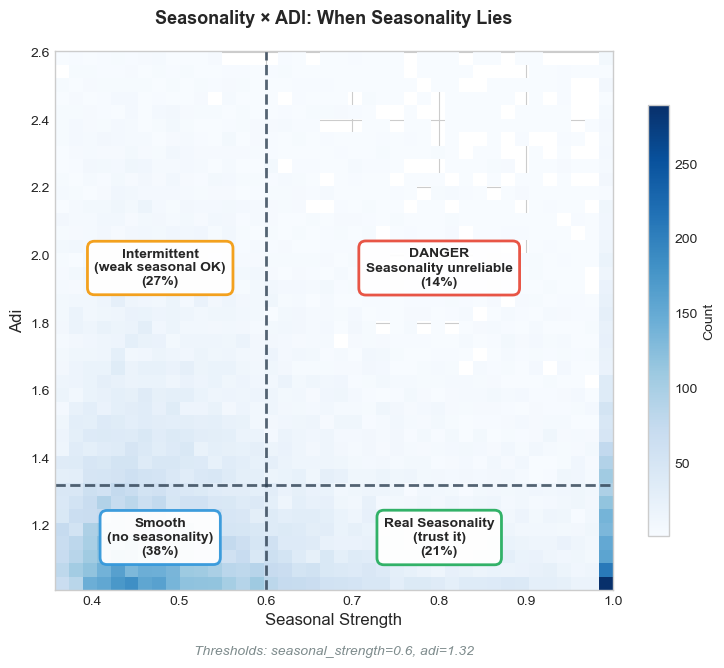

In [8]:
# When entropy is high (random), seasonal patterns may be noise
plot_metric_interaction(ld6_df, x_col='seasonal_strength', y_col='adi', 
                       title='Seasonality × ADI: When Seasonality Lies')

**Interpretation:** Series in the upper-right show "strong seasonality" but also high entropy (near-random). The seasonal component may be fitting noise. Proceed with caution.

### 4.3 Seasonality × Entropy: Patterns in Noise?

<Axes: title={'center': 'Seasonality × Entropy: Does Chaos Override Seasonality?'}, xlabel='Seasonal Strength', ylabel='Entropy'>

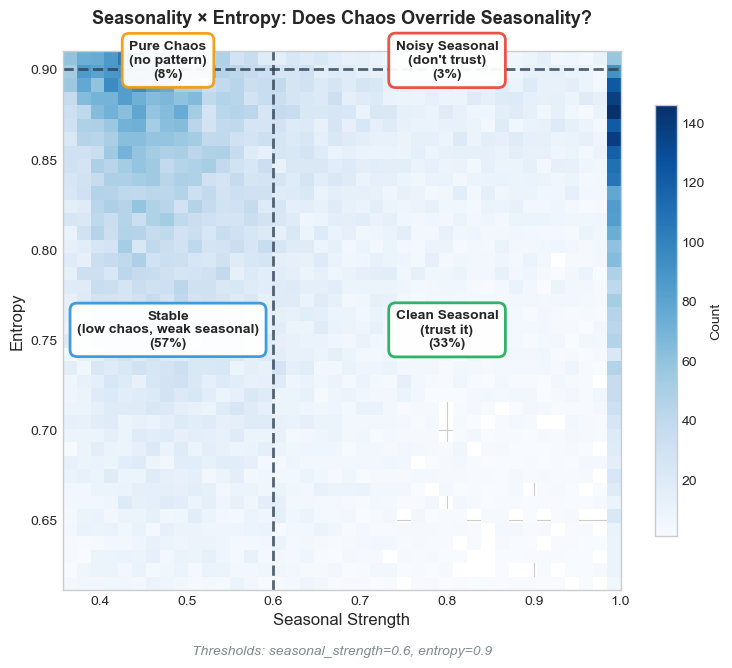

In [9]:

plot_metric_interaction(ld6_df, x_col='seasonal_strength', y_col='entropy')

The "Noisy Seasonal" quadrant (3%) shows series with high seasinality, but high entropy. Suggests it may be fitting noise.

---

## 5. Compute Structure & Chaos Scores

We collapse 6 metrics into 2 scores:
- **Structure Score**: Average of normalized (trend, seasonality, acf1) — higher = more learnable
- **Chaos Score**: Average of normalized (entropy, ADI, lumpiness) — higher = less trustworthy

### 5.1 Handle Missing Values

In [10]:
scores_df = ld6_df.copy()

# Check for NAs
na_counts = scores_df[LD6_COLS].isna().sum()
na_counts

trend                0
seasonal_strength    0
x_acf1               0
entropy              0
adi                  0
lumpiness            0
dtype: int64

### 5.2 Cap Outliers

In [11]:
# Cap extreme outliers at the 95th percentile
# Why? A few extreme values (like ADI=19) would dominate when we average

for col in CHAOS_COLS:
    cap_at = scores_df[col].quantile(0.95)
    scores_df[f'{col}_clipped'] = scores_df[col].clip(upper=cap_at)
    print(f"{col}: capped at {cap_at:.2f}")

entropy: capped at 0.91
adi: capped at 2.60
lumpiness: capped at 0.74


### 5.3 Min-Max Scaling

In [12]:
def minmax_scale(series):
    """Scale to [0, 1] range."""
    return (series - series.min()) / (series.max() - series.min())

# Normalize Structure metrics
for col in STRUCTURE_COLS:
    scores_df[f'{col}_norm'] = minmax_scale(scores_df[col])

# Normalize Chaos metrics (use clipped values)
for col in CHAOS_COLS:
    scores_df[f'{col}_norm'] = minmax_scale(scores_df[f'{col}_clipped'])

### 5.4 Compute Scores

In [13]:
# Structure = average of normalized structure metrics
structure_norm_cols = [f'{c}_norm' for c in STRUCTURE_COLS]
scores_df['structure_score'] = scores_df[structure_norm_cols].mean(axis=1)

# Chaos = average of normalized chaos metrics  
chaos_norm_cols = [f'{c}_norm' for c in CHAOS_COLS]
scores_df['chaos_score'] = scores_df[chaos_norm_cols].mean(axis=1)

### 5.5 Sanity Check: Score Distributions

After normalizing, we expect:
- Scores spread across [0,1], not piled at extremes
- Structure and Chaos distributions should differ (they measure different things)
- No large spike at 0 or 1 (would indicate over-clipping)

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Structure Score Distribution'}, xlabel='Structure Score', ylabel='Count'>,
        <Axes: title={'center': 'Chaos Score Distribution'}, xlabel='Chaos Score', ylabel='Count'>],
       dtype=object))

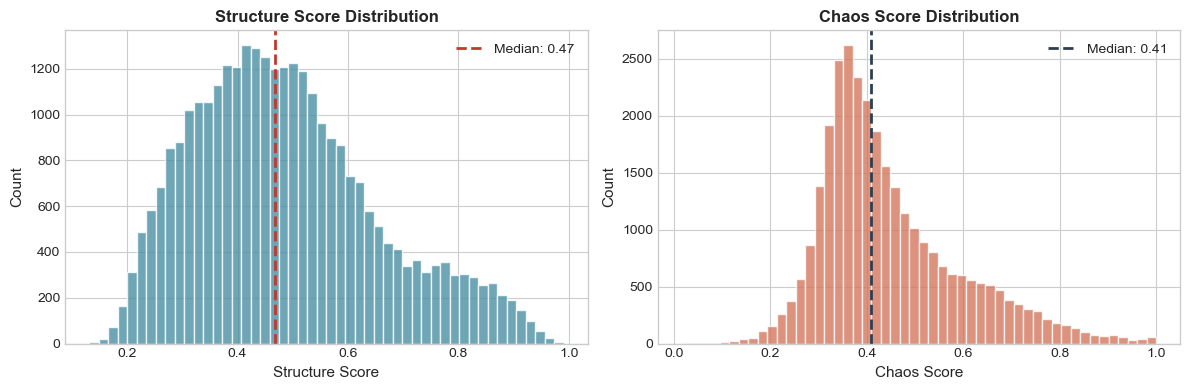

In [14]:
plot_score_distributions(scores_df)

---

## 6. Syntetos-Boylan Classification

The **Syntetos-Boylan (S-B) framework** is a classic 2×2 demand classification using just two metrics:
- **ADI** (Average Demand Interval): How often do we see non-zero demand?
- **CV²** (Coefficient of Variation squared): How variable is demand when present?

### 6.1 Assign quadrants

In [15]:
# Assign S-B quadrant using tsforge
scores_df['sb_quadrant'] = scores_df.apply(
    lambda row: assign_sb_quadrant(row['cv2'], row['adi']), axis=1
)

# Distribution
scores_df['sb_quadrant'].value_counts()

sb_quadrant
Lumpy           12491
Smooth           9614
Erratic          8380
Intermittent        5
Name: count, dtype: int64

### 6.2 Plot S-B Classification

<Axes: title={'center': 'CV² × ADI: Syntetos-Boylan Demand Classification'}, xlabel='CV² (Demand Variability)', ylabel='ADI (Average Demand Interval)'>

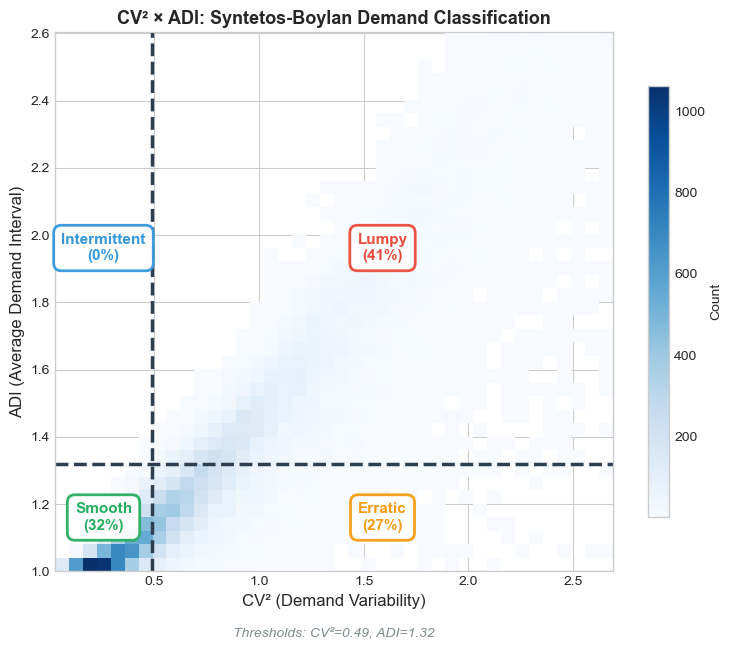

In [16]:
# Visualize S-B classification
plot_demand_classification(scores_df, adi_col='adi', cv2_col='cv2')

### 6.3 Can LD6 See What S-B Misses?

Find two series with nearly identical ADI and CV² — but different structure scores. If LD6 adds value, we should find series that S-B groups together but LD6 separates.

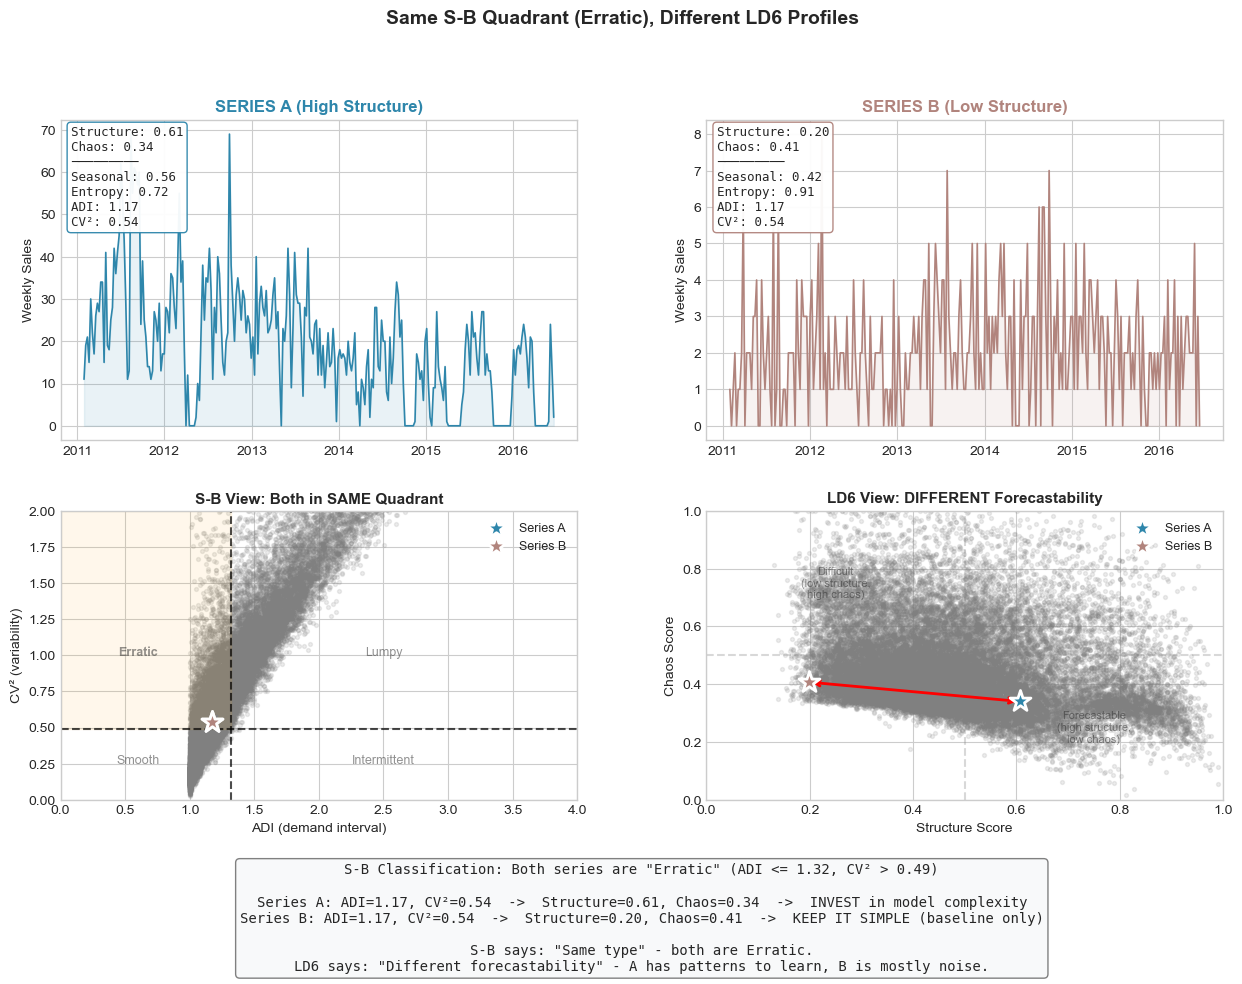

In [17]:
ff.plot_ld6_vs_sb(weekly_df, scores_df, 'Erratic');

---

## 7. Portfolio Summary

In [18]:
# Count of S-B quadrants by category
counts_by_cat = scores_df.groupby('cat_id')['sb_quadrant'].value_counts().unstack(fill_value=0)
counts_by_cat


sb_quadrant,Erratic,Intermittent,Lumpy,Smooth
cat_id,,,,
HOBBIES,1321,3,3045,1281
HOUSEHOLD,2294,0,4717,3459
FOODS,4765,2,4729,4874


In [19]:
# Percent distribution within each category
pct_by_cat = scores_df.groupby('cat_id')['sb_quadrant'].value_counts(normalize=True).mul(100).round(1).unstack(fill_value=0)
pct_by_cat

sb_quadrant,Erratic,Intermittent,Lumpy,Smooth
cat_id,,,,
HOBBIES,23.4,0.1,53.9,22.7
HOUSEHOLD,21.9,0.0,45.1,33.0
FOODS,33.2,0.0,32.9,33.9


---
## 8. Generate Report and Save Output

In [20]:
# Generate report with computed kwargs
report = ff.ModuleReport(
    "1.10",
    input_df=diagnostics,
    output_df=scores_df,
)

report.display()

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1.10 · Lie Detector 6
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

SNAPSHOT
─────────────────────────────────────────────────────────────────
       unique_id    trend  seasonal_strength  entropy      adi      cv2  structure_score  chaos_score sb_quadrant
FOODS_1_001_CA_1 0.204450           0.376623 0.850729 1.105469 0.505594         0.330351     0.485609     Erratic
FOODS_1_001_CA_2 0.223280           0.439298 0.843529 1.105469 0.503956         0.377419     0.415572     Erratic
FOODS_1_001_CA_3 0.162804           0.384099 0.895521 1.118577 0.636649         0.298169     0.376738     Erratic

PORTFOLIO OVERVIEW
─────────────────────────────────────────────────────────────────
  Series:              30,490
  Date Range:          N/A → N/A
  History (weeks):     0
  Source:              1.09 Diagnostics

MEMORY
─────────────────────────────────────────────────────────────────
  ✓ 9 MB (Small) — Fits ea

In [21]:
# Cache for downstream modules
output.save(
    df=scores_df,
    report=report,
)

✓ Report saved: /Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data/output/reports/1.10_lie_detector_report.txt
✓ Saved '1.10_lie_detector'
   Data:   data/1.10_lie_detector_output.parquet (4.47 MB, 30,490 rows)
   Report: reports/1.10_lie_detector_report.txt


PosixPath('/Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data/output/data/1.10_lie_detector_output.parquet')